# Choosing Top Real Estate Zipcodes
### With Historical Low Volatility and Increasing Values

By Valentina Fontiveros

## Objective

The objective of this study is to identify 5 optimal real estate investment opportunities in the United States.

## Methods

- Data Source: Zillow home values (1996 - 2018)
- Zipcode Selection Criteria: 

> 1. Overall increasing in value over last 20 years

> 2. Recent acceleration in value increase.

> 3. Low price volatility

- Using Arima modeling, forecast potential home values for the next __ years.

## Import Libraries

In [59]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import statsmodels.api as sm
import statistics as stats
from matplotlib.pylab import rcParams
from pandas import Grouper
from collections import Counter
plt.style.use('seaborn-bright')
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')

## Import Zillow Data and Preview

Zillow provides free access to its API. The dataset read here contains data for historical home values in the United States between 1996 and 2018. 

In [60]:
# read in data and preview
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Data Preprocessing

All numerical entries are converted to float format.
It is always important to understand how much missing data there is, so the dataset is scanned for NaN entries.

In [61]:
# Convert all data columns to type: float
for c in df.columns[7:]:
    df[c] = df[c].astype(float)
    
# Understand Percent of NaN Entries
c_entries = len(df.RegionID)
n_entries = df.size
nan_entries = df.isna().sum().sum()
print('Entries per column:                    '  , c_entries)
print('Total entries:                         '  , n_entries)
print('Total NaN entries:                     '  , nan_entries)

# Check for columns for NaNs entries greater than 10%
print('Percent of NaN entries:                '  , round(100*nan_entries/n_entries, 2))
print('Columns with 5% or more NaN Entries:   '  ,    (df.isna().sum()/c_entries > .05).sum())
print('Columns with 10% or more NaN Entries:  '  ,    (df.isna().sum()/c_entries > .1).sum())

Entries per column:                     14723
Total entries:                          4004656
Total NaN entries:                      157934
Percent of NaN entries:                 3.94
Columns with 5% or more NaN Entries:    112
Columns with 10% or more NaN Entries:   0


This is, overall, a very good quality dataset, with only 4% NaN entries.

Next, dates are transformed to datetime format. A copy of the dataset is generated for data wrangling.

In [62]:
# convert columns with dates to datetime format

pd.to_datetime(df.columns.values[7:], format='%Y-%m')



DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

## 1st Step for Zipcode Selection
### Find Zipcodes where values increased most months of the year.

The strategy pursued is to invest in real estate with a strong historical
performance. 

In [66]:
# This function takes in a dataframe and finds the zipcodes that have 
# more than a certain percentage of intervals where the value is increasing.
# returns a dataframe with the data for each zipcode identified.
def find_zips_with_positive_trend(df,percent):
    # count how many intervals are increasing in value
    increasing_zips = []
    increasing_intervals = []
    for row in range(len(df.RegionID)):
        entry_0 = 0
        increasing = 0
        decreasing = 0
        n_increasing = 0
        zipcode = df.RegionName[row]
        for column_name in df.columns[7:]:
            entry_1 = df[column_name][row]
            if entry_1 > entry_0:
                increasing += 1
            else:
                decreasing += 1 
            entry_0 = entry_1
        net_increase = increasing - decreasing
        if net_increase > 0:
            increasing_zips.append(zipcode)
            increasing_intervals.append(net_increase)
    # filter the zipcodes with percent% of intervals are positive.

    d = {'Zipcode':increasing_zips,'Increasing_Intervals': increasing_intervals}
    increasing_df = pd.DataFrame(d)
    rank_cutoff = percent * (len(df.columns)-7)
    zips_rank = increasing_df.sort_values(by='Increasing_Intervals',ascending=False)
    zips_rank = zips_rank[zips_rank.Increasing_Intervals >= rank_cutoff]
    zips = list(zips_rank['Zipcode'])
    return zips, zips_rank


In [67]:
#make a copy of the dataframe
df_c1 = df.copy()

# filter the zipcodes with 70% of intervals are positive.
zips, zips_rank = find_zips_with_positive_trend(df_c1,0.69)

In [68]:
zips_rank

,Zipcode,Increasing_Intervals
2740,37206,201
6045,37204,195
1357,80211,195
465,11216,195
1415,20003,195
4809,99502,191
1296,80210,189
2429,80521,189
6104,81101,187
4985,37216,185


## 2nd Step for Zipcode Selection:
### Find zipcodes where value has been increasing the last few years in a concave up fashion

In [69]:
#make a copy of the dataframe
df_c = df.copy()
df_c = df[df.RegionName.isin(zips)]
# Compute % change for the last few years to choose 
# zipcodes with greatest potential for growth in the 
# coming years.

df_c['delta1'] =  (df_c['2018-04'] - df_c['2017-12'])/(df_c['2017-12'])
df_c['delta2'] =  (df_c['2018-04'] - df_c['2017-04'])/(df_c['2017-04'])
df_c['delta3'] =  (df_c['2017-04'] - df_c['2016-04'])/(df_c['2016-04'])
df_c['delta4'] =  (df_c['2016-04'] - df_c['2015-04'])/(df_c['2015-04'])

# Created a filter to extract zipcodes 
d1 = df_c[(df_c.delta1 >= .02)  & (df_c.delta1 <= .10) & 
          (df_c.delta2 >= .02)  & 
          (df_c.delta3 >= 0)    &
          (df_c.delta4 >= 0)].sort_values(by='delta1',ascending=False)

# create a list with the zipcodes that satisfy above criteria
zips = list(d1.RegionName)
zips

[80904, 80212, 2446, 11221, 80211, 80210, 11216, 98103, 37216, 80521, 20009]


## 3rd Step for Zipcode Selection:
### Find zipcodes where values are not volatile (low standard deviation)


In [70]:
# filter out zipcodes with standard deviations greater than a threshhold.
zips_filt = []
for z in zips:
    df_z = df_c[df_c.RegionName==z]
    ts = df_z.values[0][7:]
    std = np.std(ts)
    if (std  < 120000):
        zips_filt.append(z)

len(zips_filt)


6

In [71]:
zips_filt

[80904, 80212, 80211, 80210, 37216, 80521]

In [11]:
#all but one of these are in colorado.
#take out the odd ball.

zips_filt = [80904, 80212, 80211, 80210, 80521]

# Optimize data format for analysis

In [12]:
# define a function to convert from long format to short format
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','SizeRank','RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted.set_index('time',inplace=True)
    melted.dropna(inplace=True)
    return melted
    #return melted.groupby('time').aggregate({'value':'mean'})

In [13]:
# create a short format dataframe to hold data for top zipcodes
zip_df = pd.DataFrame()
for z in zips_filt:
    d = melt_data(df[df.RegionName==z])
    zip_df = pd.concat([d,zip_df])
zip_df.head()

,RegionID,SizeRank,RegionName,City,State,Metro,CountyName,value
time,,,,,,,,
1996-04-01,93445,2492,80521,Fort Collins,CO,Fort Collins,Larimer,113900.0
1996-05-01,93445,2492,80521,Fort Collins,CO,Fort Collins,Larimer,114200.0
1996-06-01,93445,2492,80521,Fort Collins,CO,Fort Collins,Larimer,114400.0
1996-07-01,93445,2492,80521,Fort Collins,CO,Fort Collins,Larimer,114700.0
1996-08-01,93445,2492,80521,Fort Collins,CO,Fort Collins,Larimer,115000.0


In [14]:
zip_df.RegionName.unique()

array([80521, 80210, 80211, 80212, 80904])

# Data Visualization

Plot overall trend of values in zipcodes selected

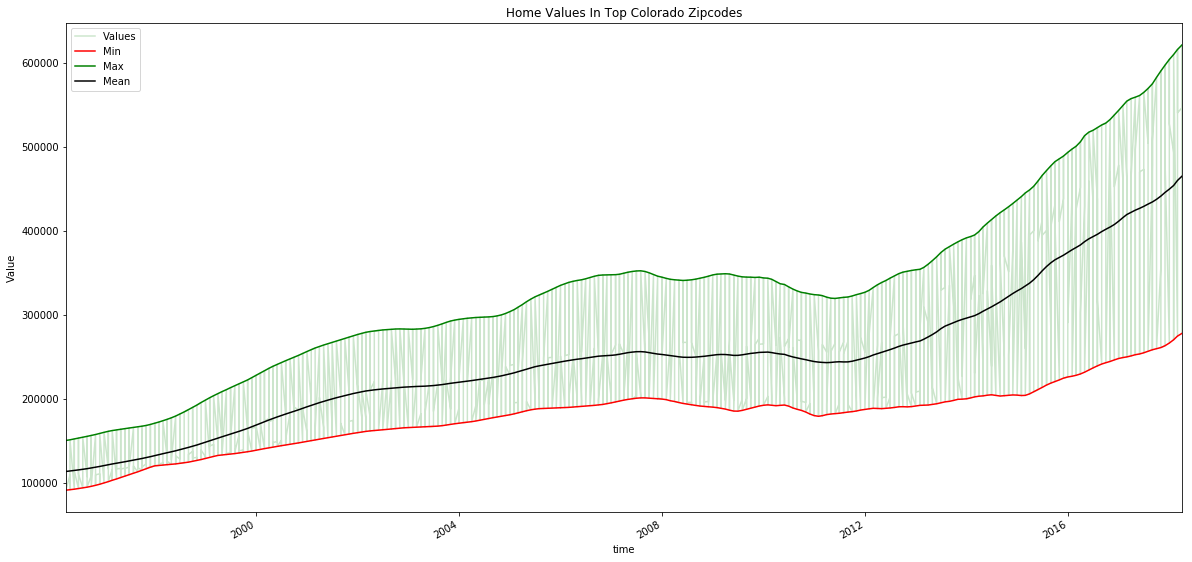

In [15]:
# plot the entirety of data for all zipcodes and observe overall trend
# make sure this satisfies criteria: (Low STD and overall increasing trend)

zip_df.value.plot(figsize=(20,10),label='Values',color='green',alpha=0.2)
min_ = zip_df.groupby('time').aggregate({'value':'min'})
max_ = zip_df.groupby('time').aggregate({'value':'max'})
mean_ = zip_df.groupby('time').aggregate({'value':'mean'})
plt.plot(min_, color= 'red',label='Min')
plt.plot(max_, color='green',label = 'Max')
plt.plot(mean_, color= 'black',label= 'Mean')
plt.legend()
plt.title('Home Values In Top Colorado Zipcodes')
plt.ylabel('Value')
plt.show()

Plot each zipcode for QC

Text(0.5, 0.98, 'Top Zipcodes')

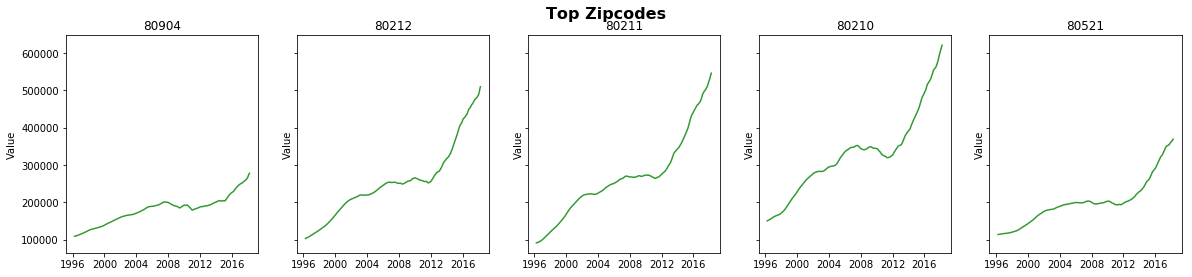

In [16]:
fig, axs = plt.subplots(1,5,figsize=(20,4),sharey=True)
for ax, column, index in zip(axs,zips_filt, range(0,5)):
    ax.plot(zip_df[zip_df.RegionName ==column].value, color='green',alpha=0.8)
    ax.set_title(column)
    ax.set_ylabel('Value')
fig.suptitle('Top Zipcodes', fontsize=16, fontweight='bold')

All looks good

# Modeling and Forecasting - ARIMA

### Stationarity test

In [17]:
zipcodes = zip_df.RegionName.sort_values().unique()

from statsmodels.tsa.stattools import adfuller
from numpy import log

for z in zipcodes: 
    df_z = zip_df[zip_df.RegionName == z]
    result = adfuller(df_z.value.dropna())
    print('Zip: ', z)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

Zip:  80210
ADF Statistic: 0.789878
p-value: 0.991471
Zip:  80211
ADF Statistic: 1.385263
p-value: 0.997046
Zip:  80212
ADF Statistic: 1.105638
p-value: 0.995264
Zip:  80521
ADF Statistic: 0.196868
p-value: 0.972085
Zip:  80904
ADF Statistic: 0.899414
p-value: 0.993083


None of the series are stationary, as expected

## Difference and Autocorrelation Plots

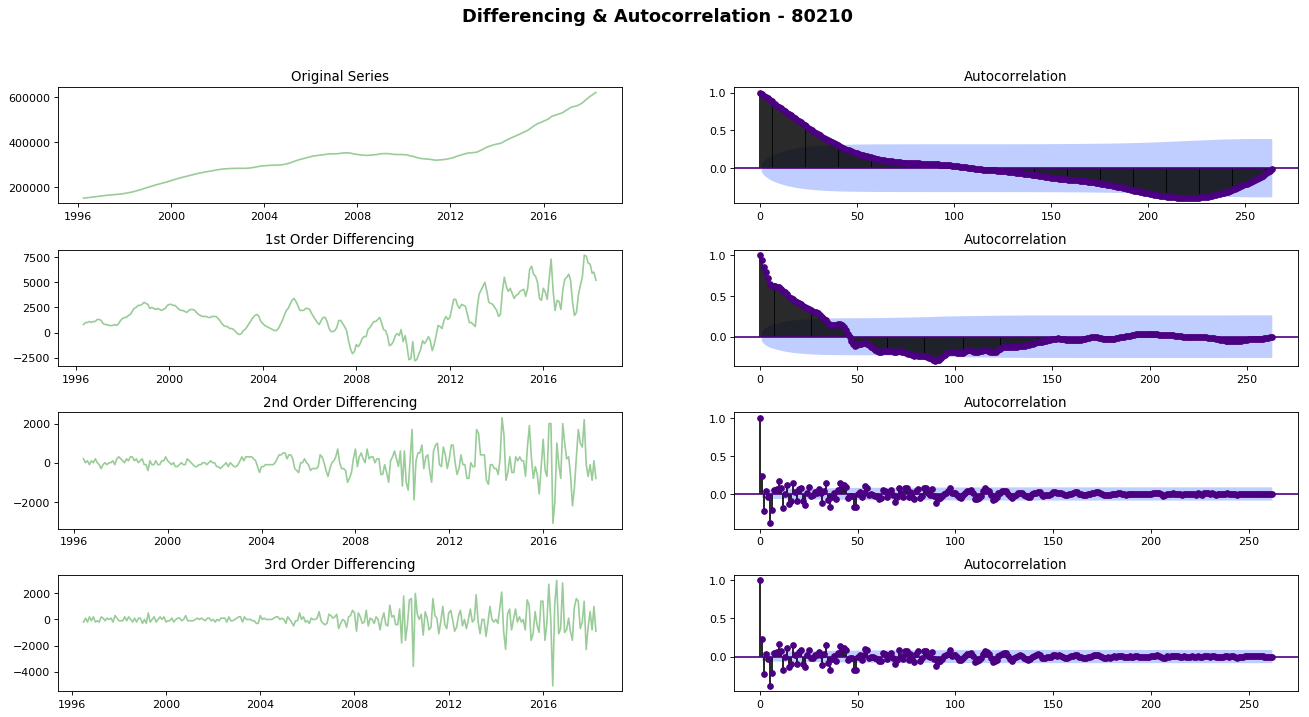

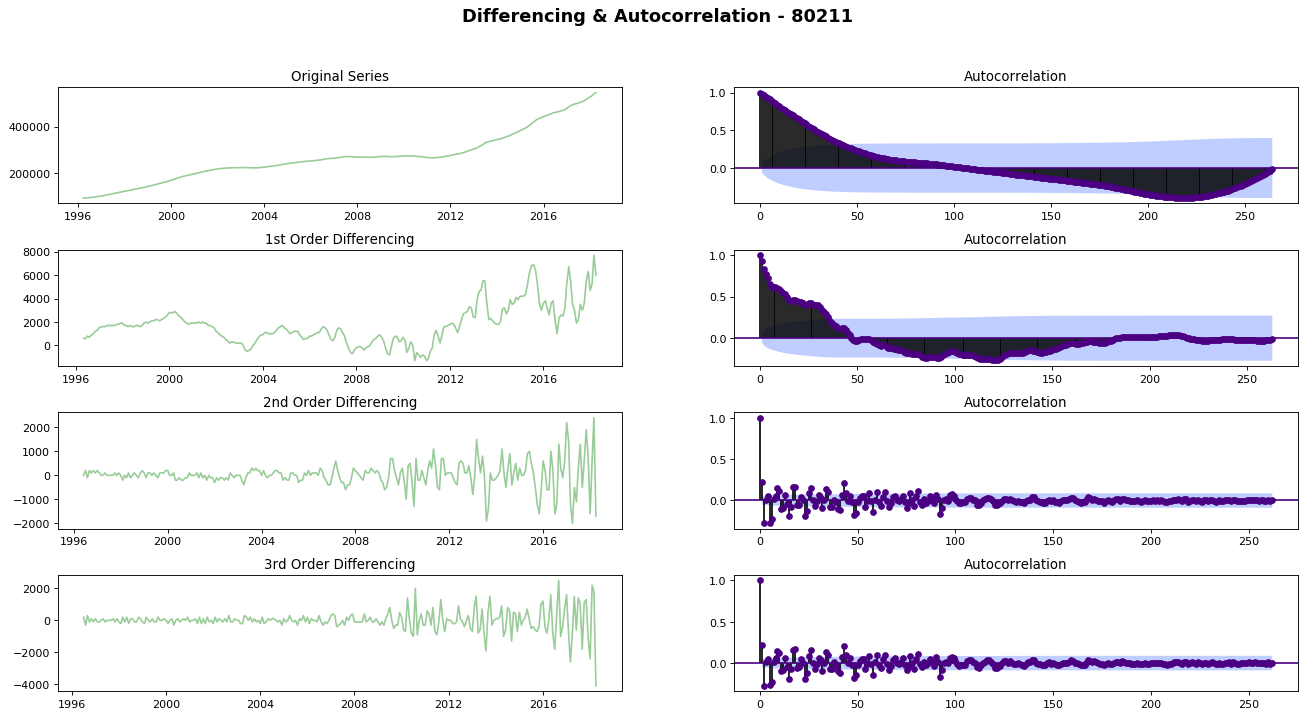

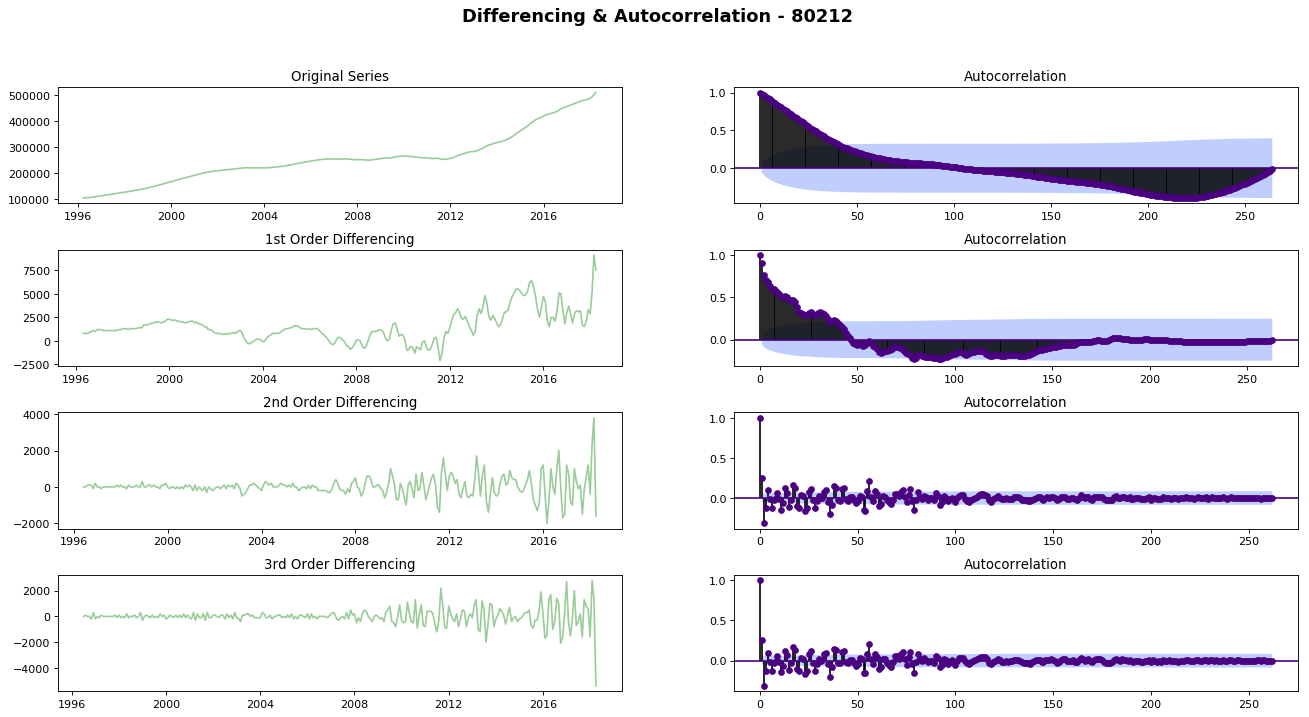

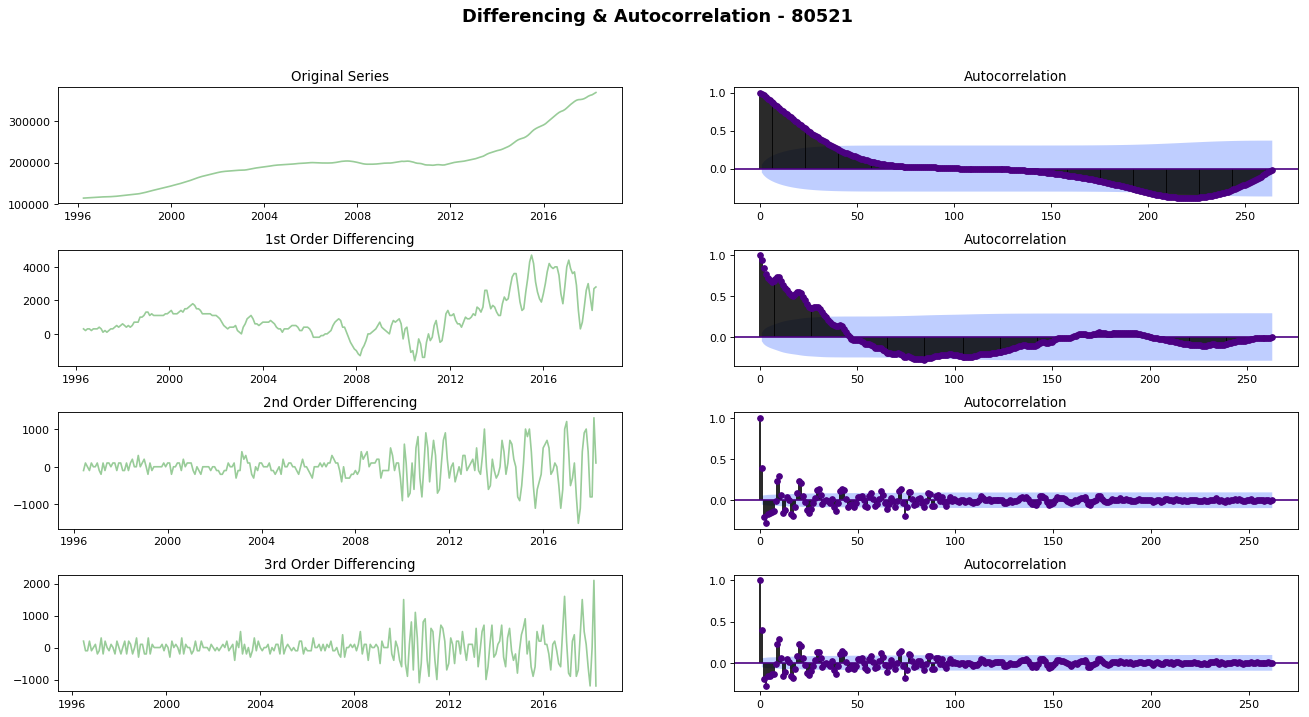

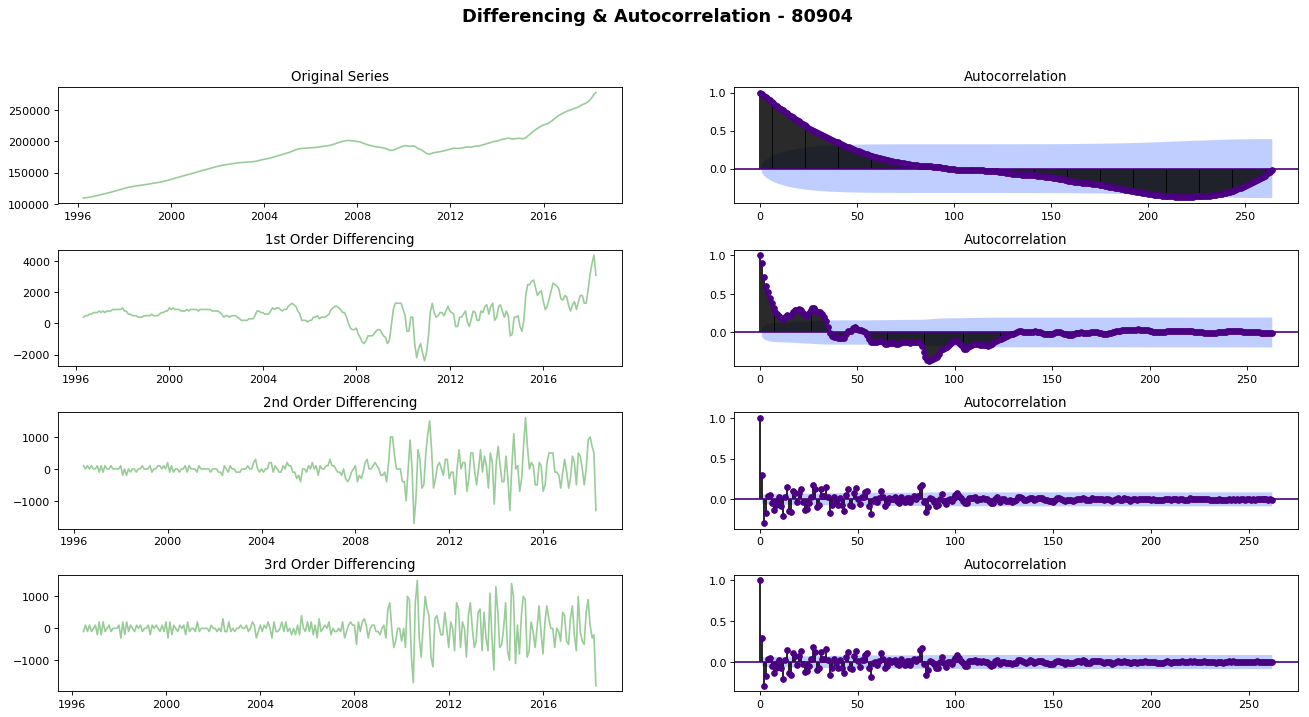

In [18]:
# check ACF and PACF

plt.rcParams.update({'figure.figsize':(20,10), 'figure.dpi':80})
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Import data
for z in zipcodes: 
    df_z = zip_df[zip_df.RegionName == z]
# Original Series
    fig, axes = plt.subplots(4, 2)
    axes[0, 0].plot(df_z.value,color='green',alpha=0.4); axes[0, 0].set_title('Original Series',fontsize=12)
    plot_acf(df_z.value, ax=axes[0, 1], color='indigo',alpha=0.4)

    # 1st Differencing
    axes[1, 0].plot(df_z.value.diff(), color='green',alpha=0.4); axes[1, 0].set_title('1st Order Differencing',fontsize=12)
    plot_acf(df_z.value.diff().dropna(), ax=axes[1, 1], color='indigo',alpha=0.4)

    # 2nd Differencing
    axes[2, 0].plot(df_z.value.diff().diff(), color='green',alpha=0.4); axes[2, 0].set_title('2nd Order Differencing',fontsize=12)
    plot_acf(df_z.value.diff().diff().dropna(), color='indigo',alpha=0.4, ax=axes[2, 1])
    
     # 3nd Differencing
    axes[3, 0].plot(df_z.value.diff().diff().diff(), color='green',alpha=0.4); axes[3, 0].set_title('3rd Order Differencing',fontsize=12)
    plot_acf(df_z.value.diff().diff().dropna(), ax=axes[3, 1],  color='indigo',alpha=0.4)

    fig.suptitle('Differencing & Autocorrelation - ' + str(z), fontsize=16, fontweight='bold')
    plt.subplots_adjust(hspace = 0.4 )
    plt.show()


In [19]:
zip_df.index[-40:]

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', freq=None)

In [20]:
 pd.date_range('2018-05-01', periods=48, freq='M')


DatetimeIndex(['2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30'],
              dtype='datetime64[ns]', freq='M')

We are not able to reduce heteroscedasticity

## Seasonal Decomposition, Model Building, and Forecasting

Zip:  80210
ADF Statistic Residual: -3.737206
p-value: 0.003619


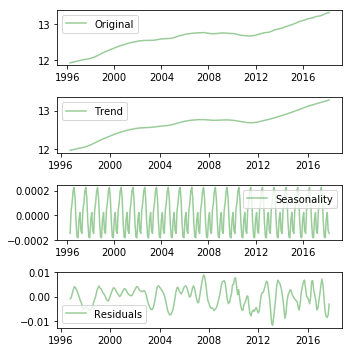

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4154.981, BIC=4169.270, Fit time=0.247 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4151.770, BIC=4158.914, Fit time=0.010 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4153.483, BIC=4164.199, Fit time=0.032 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4154.530, BIC=4165.246, Fit time=0.035 seconds
Total fit time: 0.335 seconds
80210
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2073.885
Date:                Thu, 15 Aug 2019   AIC                           4151.770
Time:                        14:54:57   BIC                           4158.914
Sample:                             0   HQIC                          4154.641
                                - 265                         

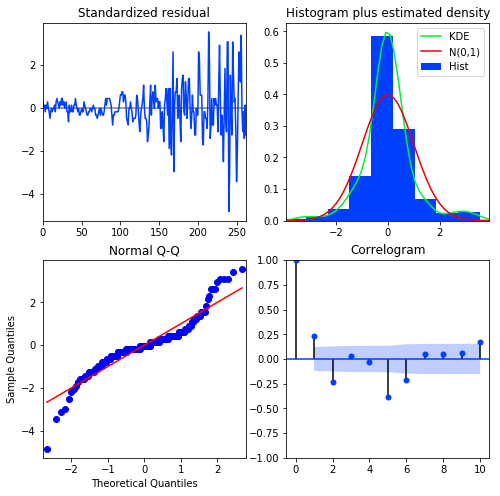

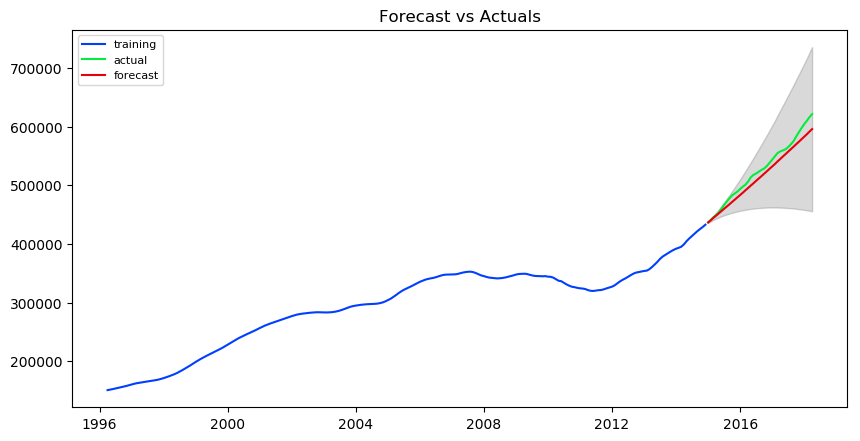

Mean Error : -10909.01345291477


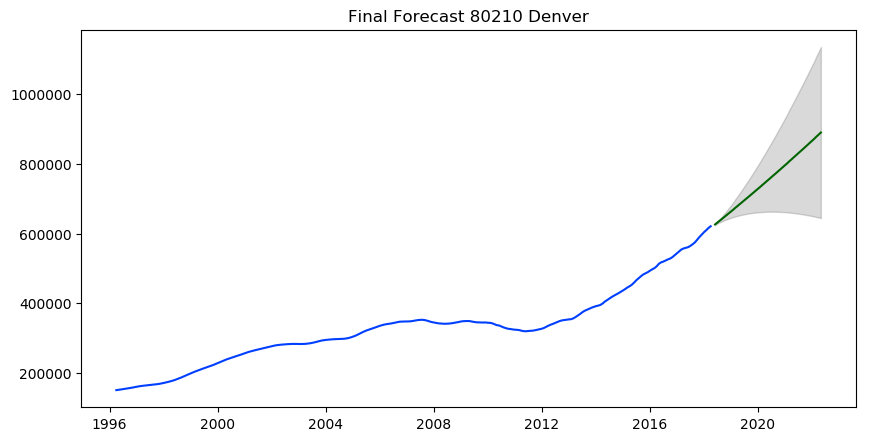

Zip:  80211
ADF Statistic Residual: -4.418188
p-value: 0.000276


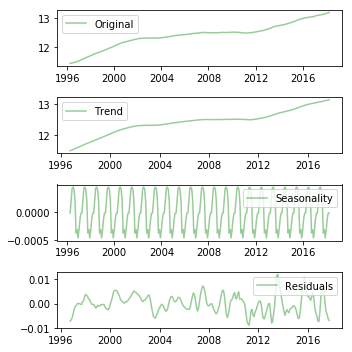

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4053.545, BIC=4060.689, Fit time=0.012 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4052.712, BIC=4063.428, Fit time=0.036 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4052.163, BIC=4062.879, Fit time=0.092 seconds
Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=4050.125, BIC=4064.414, Fit time=0.056 seconds
Fit ARIMA: order=(1, 2, 3) seasonal_order=(0, 0, 0, 1); AIC=4054.275, BIC=4075.708, Fit time=0.074 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=4048.995, BIC=4066.856, Fit time=0.348 seconds
Fit ARIMA: order=(2, 2, 3) seasonal_order=(0, 0, 0, 1); AIC=4054.810, BIC=4079.815, Fit time=0.226 seconds
Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=4051.439, BIC=4072.872, Fit time=0.374 seconds
Total fit time: 1.228 seconds
80211
             

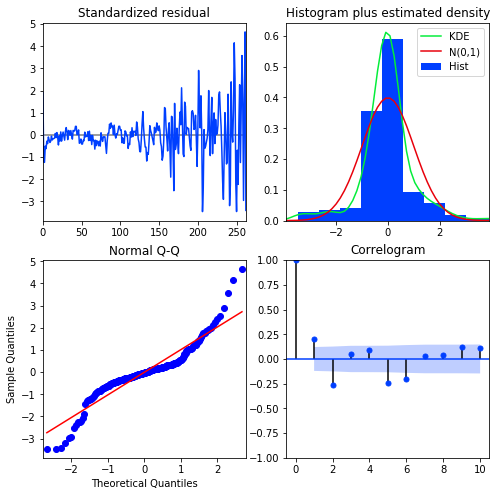

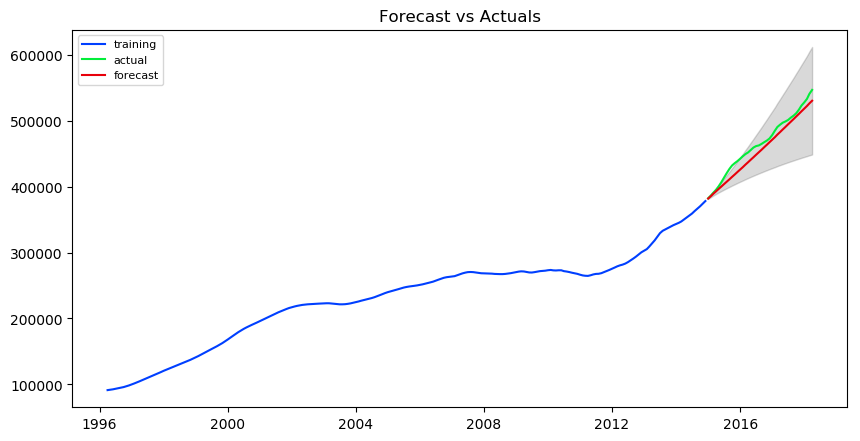

Mean Error : -9947.714441377326


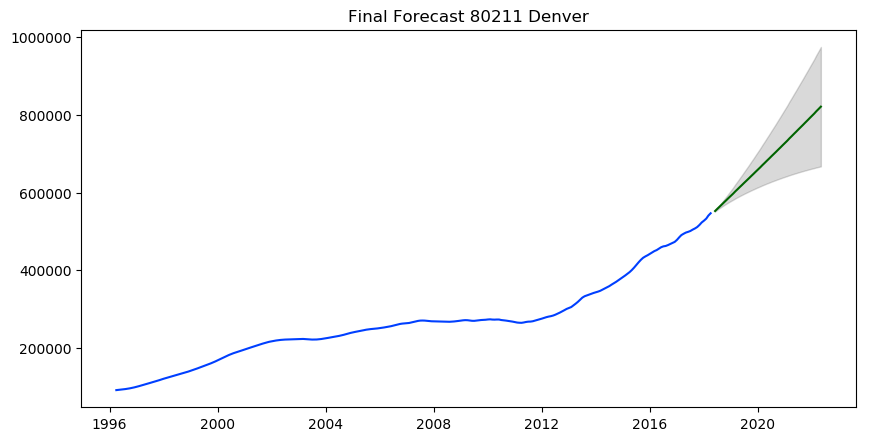

Zip:  80212
ADF Statistic Residual: -4.702324
p-value: 0.000083


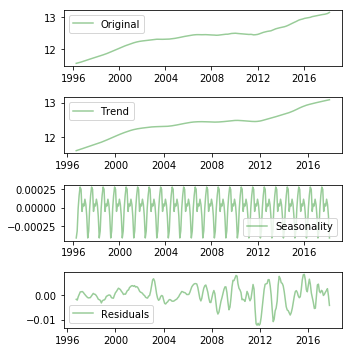

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4097.451, BIC=4111.740, Fit time=0.236 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4097.748, BIC=4104.893, Fit time=0.010 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4097.035, BIC=4107.752, Fit time=0.031 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4096.487, BIC=4107.203, Fit time=0.087 seconds
Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=4095.597, BIC=4109.885, Fit time=0.134 seconds
Fit ARIMA: order=(1, 2, 3) seasonal_order=(0, 0, 0, 1); AIC=4097.707, BIC=4119.140, Fit time=0.357 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=4096.015, BIC=4113.876, Fit time=0.267 seconds
Fit ARIMA: order=(0, 2, 3) seasonal_order=(0, 0, 0, 1); AIC=4095.680, BIC=4113.541, Fit time=0.148 seconds
Total fit time: 1.279 seconds
80212
                           Statespace Model Results                           
Dep. Variable:               

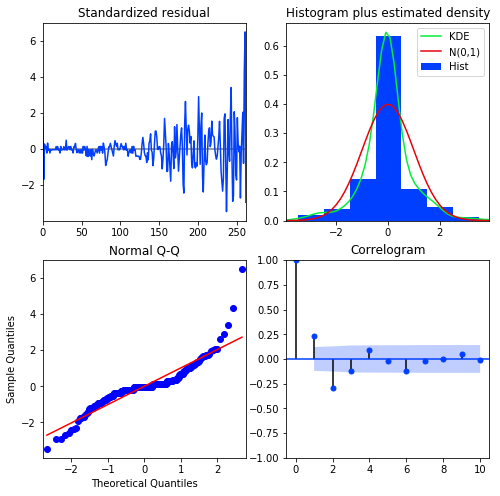

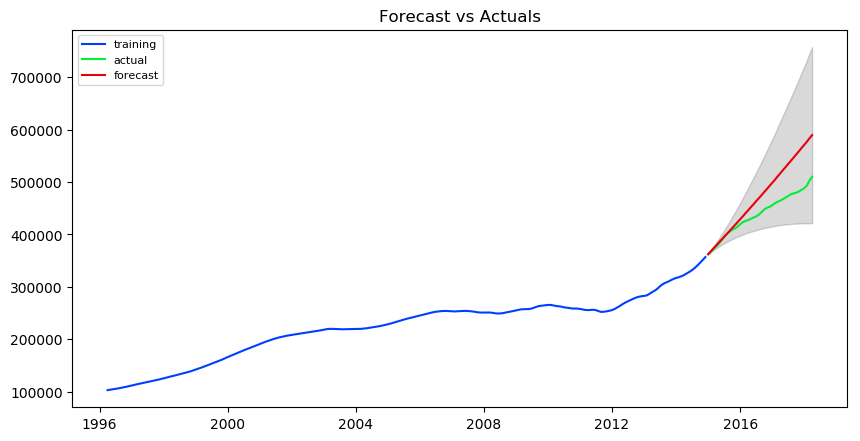

Mean Error : 34484.54034996942


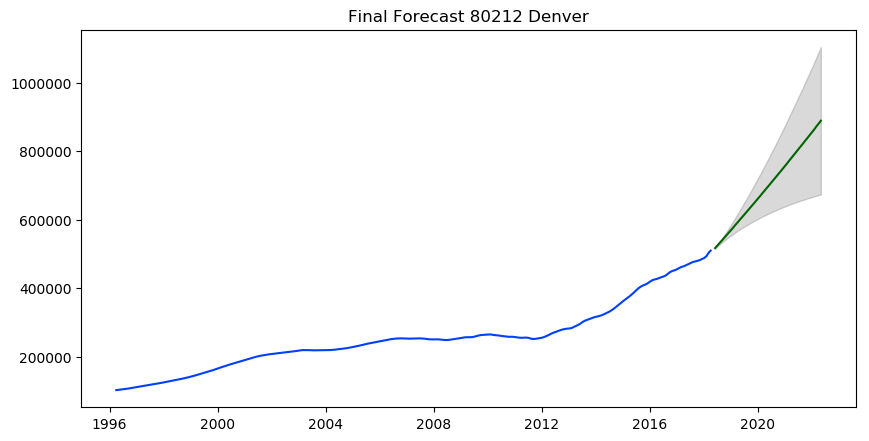

Zip:  80521
ADF Statistic Residual: -3.809518
p-value: 0.002811


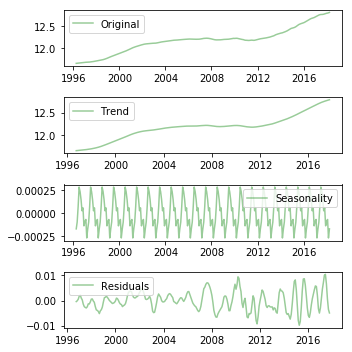

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=3869.610, BIC=3883.899, Fit time=0.143 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=3877.846, BIC=3884.991, Fit time=0.010 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=3869.604, BIC=3880.321, Fit time=0.115 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=3868.471, BIC=3879.188, Fit time=0.091 seconds
Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=3868.553, BIC=3882.842, Fit time=0.131 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.499 seconds
80521
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1931.236
Date:                Thu, 15 Aug 2019   AIC                           3868.471
Time:             

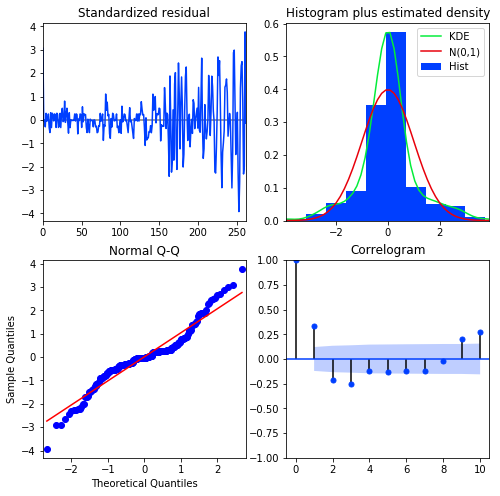

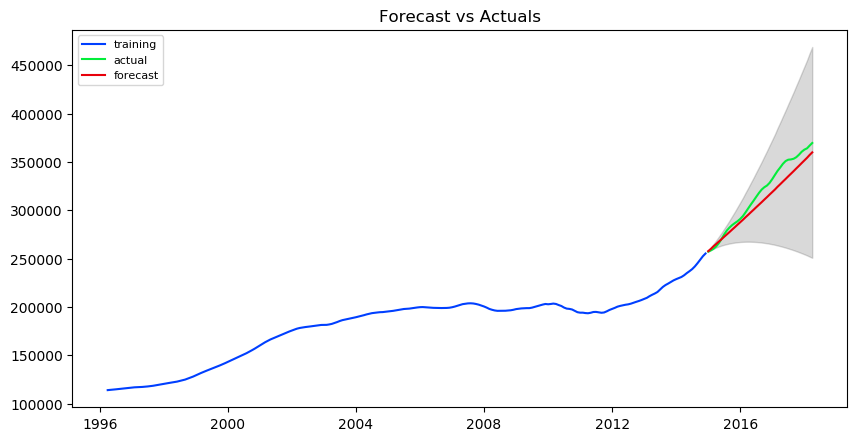

Mean Error : -8581.45084546405


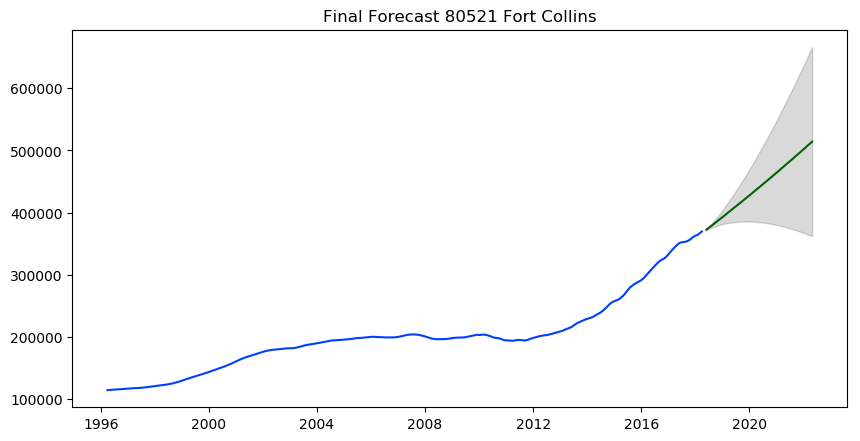

Zip:  80904
ADF Statistic Residual: -5.548130
p-value: 0.000002


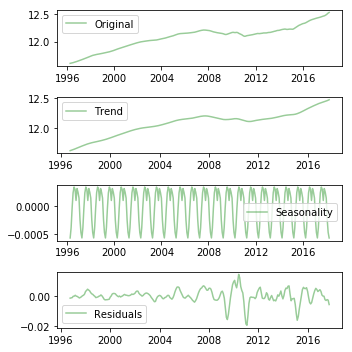

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=3872.776, BIC=3887.064, Fit time=0.167 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=3874.927, BIC=3882.071, Fit time=0.010 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=3872.888, BIC=3883.604, Fit time=0.083 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=3872.287, BIC=3883.003, Fit time=0.116 seconds
Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=3870.476, BIC=3884.765, Fit time=0.138 seconds
Fit ARIMA: order=(1, 2, 3) seasonal_order=(0, 0, 0, 1); AIC=3871.713, BIC=3893.146, Fit time=0.250 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=3869.580, BIC=3887.441, Fit time=0.335 seconds
Fit ARIMA: order=(2, 2, 3) seasonal_order=(0, 0, 0, 1); AIC=3873.720, BIC=3898.725, Fit time=0.376 seconds
Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=3871.863, BIC=3893.296, Fit time=0.377 seconds
Total fit time: 1.861 seconds
80904
 

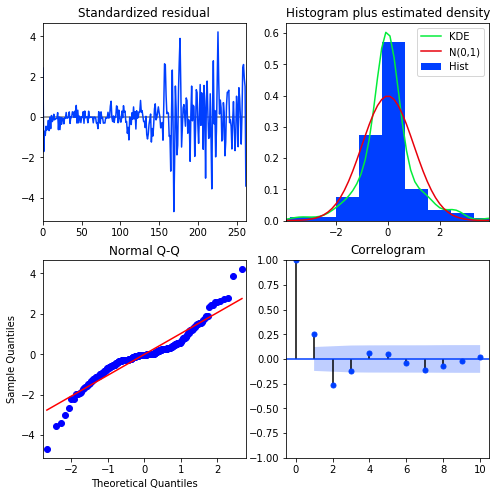

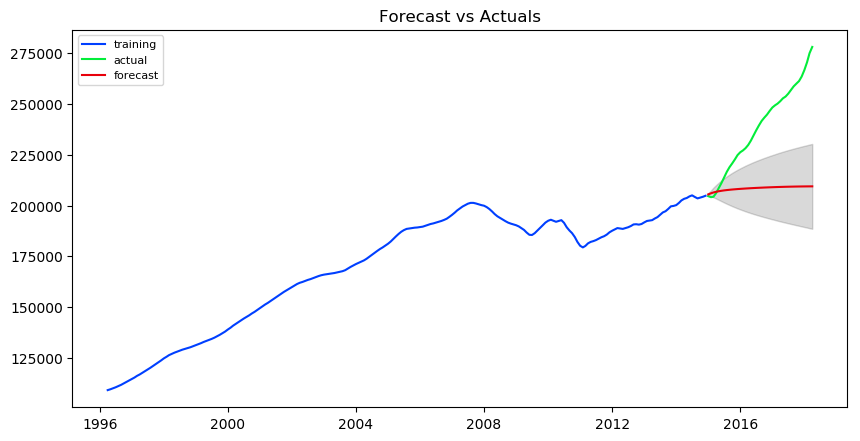

Mean Error : -29985.191696407903


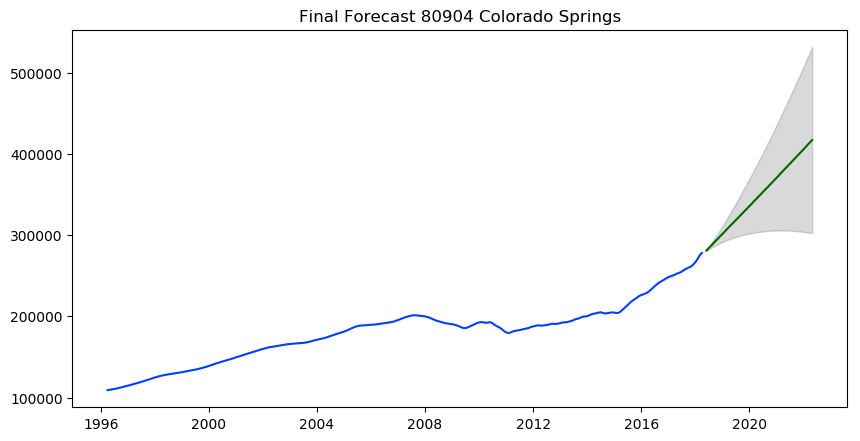

In [120]:

# compute residuals and create an ARMA model of the residuals.

from statsmodels.tsa.seasonal import seasonal_decompose

residuals_list = []
for z in zipcodes: 
    df_z = zip_df[zip_df.RegionName == z]
    ts = df_z.value
    decomposition = seasonal_decompose(np.log(ts))

    # Gather the trend, seasonality and noise of decomposed object
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    df_z['res'] = residual
    residuals_list.append(residual)
    
    # Plot gathered statistics
    plt.figure(figsize=(5,5))
    plt.subplot(411)
    plt.plot(np.log(ts), label='Original', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.tight_layout()
    result = adfuller(residual.dropna())
    print('Zip: ', z)
    print('ADF Statistic Residual: %f' % result[0])
    print('p-value: %f' % result[1])
    plt.show()
    

    model = pm.auto_arima(df_z.value.dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    print(z)
    print(model.summary())
    model.plot_diagnostics(figsize=(8, 8))
    plt.show()
    
    #============= PLOT TRAIN AND TEST =========
    #df_z.reset_index(inplace=True)
    train = df_z.value.dropna()[:225]
    test = df_z.value.dropna()[225:]
    
    test_index = zip_df.index[-40:]
    model2 = ARIMA(train, order=model.order)
    fitted = model2.fit(disp=-1)  
                   
    # Forecast
    fc, se, conf = fitted.forecast(40, alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_index)
    lower_series = pd.Series(conf[:, 0], index=test_index)
    upper_series = pd.Series(conf[:, 1], index=test_index)

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    print('Mean Error :', np.mean(fc_series - test))
    
    
    #==============PLOT FORECAST =========================
    #df_z.reset_index(inplace=True)
    n_periods = 48
    fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    #index_of_fc = np.arange(len(df_z.value), len(df_z.value)+n_periods)
    
    index_of_fc = pd.date_range('2018-05-01', periods=48, freq='M')
    # make series for plotting purpose
    fc_series = pd.Series(fc, index=(index_of_fc))
    lower_series = pd.Series(confint[:, 0], index=(index_of_fc))
    upper_series = pd.Series(confint[:, 1], index=(index_of_fc))

    # Plot
    plt.figure(figsize=(10,5), dpi=100)

    plt.plot(fc_series, color='darkgreen')
    plt.plot(df_z.value)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)

    plt.title("Final Forecast " + str(z) + ' ' + df_z.City[0])
    plt.show()



# Interpreting Results

Zipcodes in Colorado for the most part were amenable to modeling.
Zipcode in Tenessee behaved differently, outperformed forecast.

Although it is not guaranteed, if values in Colorado continue current trend,
investing in the zipcodes selected should be worthwhile.

Assumption: This model is purely based on historical trends and 
does not take into account any economical or other external factor